In [1]:
import ee
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import geemap
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
ee.Initialize()

### define parameters

In [3]:
# import urban-img and terrain data
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

# import the terrain image
DEM = ee.Image("USGS/SRTMGL1_003")
SLOPE = ee.Terrain.slope(DEM).toUint8()

# import the points for calculating AUC
pt = ee.FeatureCollection("users/wangjinzhulala/GEE_TF/ROC_AUC/random_pt_30k")

In [4]:
# # calculate the distance to urban image
# Distance = [img.distance(ee.Kernel.euclidean(200)).toInt() for img in urban_each_year]

# # export the distance img to gee-asset
# for yr,img in zip(year,Distance):
    
#     dist_name = f'Distance_{yr}'
    
#     task = ee.batch.Export.image.toAsset(   image =   img,   
#                                             description=dist_name,
#                                             assetId=f'users/wangjinzhulala/GEE_TF/Distance_to_urban/{dist_name}',
#                                             region=region.geometry(),
#                                             scale=30,    
#                                             maxPixels=int(1e13))
#     task.start()
    
#     print(dist_name)

In [5]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [6]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
    # get the t0 val/img
    t0 = k
        
    # get the t1;t2
    if v == 2:
        pass
    else:
        for val in range(v-1,1,-1):
            prj_val = val - (v - val)
            
            if  prj_val>0:
                
                prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                
                t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
                t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                                
                proj_yr.append((t0,t1,t2))

In [7]:
proj_yr

[('1990_1992', '1993_1995', '1996_1998'),
 ('1990_1992', '1996_1998', '2002_2004'),
 ('1990_1992', '1999_2001', '2008_2010'),
 ('1990_1992', '2002_2004', '2014_2016'),
 ('1993_1995', '1996_1998', '1999_2001'),
 ('1993_1995', '1999_2001', '2005_2007'),
 ('1993_1995', '2002_2004', '2011_2013'),
 ('1993_1995', '2005_2007', '2017_2019'),
 ('1996_1998', '1999_2001', '2002_2004'),
 ('1996_1998', '2002_2004', '2008_2010'),
 ('1996_1998', '2005_2007', '2014_2016'),
 ('1999_2001', '2002_2004', '2005_2007'),
 ('1999_2001', '2005_2007', '2011_2013'),
 ('1999_2001', '2008_2010', '2017_2019'),
 ('2002_2004', '2005_2007', '2008_2010'),
 ('2002_2004', '2008_2010', '2014_2016'),
 ('2005_2007', '2008_2010', '2011_2013'),
 ('2005_2007', '2011_2013', '2017_2019'),
 ('2008_2010', '2011_2013', '2014_2016'),
 ('2011_2013', '2014_2016', '2017_2019')]

### compute the urban/terrain/distance image

In [8]:
# create the training patch

urban_prj_data = []
for t in proj_yr:
    
    # get the time
    t0 = t[0]
    t1 = t[1]
    t2 = t[2]
    proj_times = year_img_val_dict[t0] - year_img_val_dict[t1]
    proj_years = proj_times*3
    
    # get the built-up layer
    t0_img,t1_img,t2_img = [urban.gte(year_img_val_dict[yr]).rename(f'built_up_t{i}') for i,yr in enumerate(t)]
    
    # get the expansion mask
    expansion_mask = t1_img.subtract(t0_img).rename('expansion')
    expansion_prj  = t2_img.subtract(t1_img).rename('pred_validation')
    
    # get the distance to built-up layer
    Distance_t0 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t0}')
    Distance_t1 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t1}')

    # get the fcnn probability map; Note divede the img by 10000
    FCNN_prob = ee.ImageCollection(f"users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_{t0}_and_{t1}_prj_{t2}").mosaic().divide(10000)
    
    # add patch to a dict
    urban_prj_data.append([t0,t1,t2,t0_img,t1_img,t2_img,proj_times,proj_years,
                           expansion_mask,expansion_prj,Distance_t0,Distance_t1,FCNN_prob])

In [9]:
# put all data into a df
urban_prj_data_df = pd.DataFrame(urban_prj_data,columns = ['t0','t1','t2','t0_img','t1_img','t2_img','proj_times','proj_years',
                                                           'expansion_mask','expansion_prj','Distance_t0','Distance_t1','FCNN_prob'])
urban_prj_data_df

,t0,t1,t2,t0_img,t1_img,t2_img,proj_times,proj_years,expansion_mask,expansion_prj,Distance_t0,Distance_t1,FCNN_prob
0,1990_1992,1993_1995,1996_1998,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,1990_1992,1996_1998,2002_2004,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,1990_1992,1999_2001,2008_2010,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",3,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,1990_1992,2002_2004,2014_2016,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",4,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,1993_1995,1996_1998,1999_2001,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,1993_1995,1999_2001,2005_2007,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,1993_1995,2002_2004,2011_2013,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",3,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,1993_1995,2005_2007,2017_2019,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",4,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,1996_1998,1999_2001,2002_2004,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functi

### compute the frequency of factors (DEM/SLOPE/Distance) in urban-expansion mask

In [9]:
for idx,row in urban_prj_data_df.iterrows():
    
    # get parameters
    t0,t1,t2 = row['t0'],row['t1'],row['t2']
    Distance_t0 = row['Distance_t0']
    expansion_mask = row['expansion_mask']

    # compute the DEM-frequency
    freq_DEM = DEM.updateMask(expansion_mask).reduceRegion( reducer=ee.Reducer.frequencyHistogram(),
                                                  geometry=region.geometry().bounds(),
                                                  scale=30,
                                                  maxPixels=int(1e13)) 

    # compute the SLOPE-frequency
    freq_SLOPE = SLOPE.updateMask(expansion_mask).reduceRegion( reducer=ee.Reducer.frequencyHistogram(),
                                                      geometry=region.geometry().bounds(),
                                                      scale=30,
                                                      maxPixels=int(1e13))

    # compute the distance-frequency
    freq_Distance = Distance_t0.updateMask(expansion_mask).reduceRegion( reducer=ee.Reducer.frequencyHistogram(),
                                                        geometry=region.geometry().bounds(),
                                                        scale=30,
                                                        maxPixels=int(1e13))

    # get the values from above gee-instance 
    dict_dem = {int(k):[int(v)] for k,v in freq_DEM.getInfo()['elevation'].items()}
    dict_slope = {int(k):[int(v)] for k,v in freq_SLOPE.getInfo()['slope'].items()}
    dict_distance = {int(k):[int(v)] for k,v in freq_Distance.getInfo()['b1'].items()}

    # conver the values to dfs
    df_dem = pd.DataFrame(dict_dem).T.sort_index()
    df_dem.reset_index(inplace=True)
    df_dem.columns = ['original_val','count']
    
    df_slope = pd.DataFrame(dict_slope).T.sort_index()
    df_slope.reset_index(inplace=True)
    df_slope.columns = ['original_val','count']
    
    df_distance = pd.DataFrame(dict_distance).T.sort_index()
    df_distance.reset_index(inplace=True)
    df_distance.columns = ['original_val','count']

    # save dfs to disk
    df_dem.to_csv(f'./Result/df_dem_{t0}_and_{t1}_prj_{t2}.csv',index=False)
    df_slope.to_csv(f'./Result/df_slope_{t0}_and_{t1}_prj_{t2}.csv',index=False)
    df_distance.to_csv(f'./Result/df_distance_{t0}_and_{t1}_prj_{t2}.csv',index=False)
    
    # print out the process
    print(f'{t0}_and_{t1}_prj_{t2} completed!')

1990_1992_and_1993_1995_prj_1996_1998 completed!
1990_1992_and_1996_1998_prj_2002_2004 completed!
1990_1992_and_1999_2001_prj_2008_2010 completed!
1990_1992_and_2002_2004_prj_2014_2016 completed!
1993_1995_and_1996_1998_prj_1999_2001 completed!
1993_1995_and_1999_2001_prj_2005_2007 completed!
1993_1995_and_2002_2004_prj_2011_2013 completed!
1993_1995_and_2005_2007_prj_2017_2019 completed!
1996_1998_and_1999_2001_prj_2002_2004 completed!
1996_1998_and_2002_2004_prj_2008_2010 completed!
1996_1998_and_2005_2007_prj_2014_2016 completed!
1999_2001_and_2002_2004_prj_2005_2007 completed!
1999_2001_and_2005_2007_prj_2011_2013 completed!
1999_2001_and_2008_2010_prj_2017_2019 completed!
2002_2004_and_2005_2007_prj_2008_2010 completed!
2002_2004_and_2008_2010_prj_2014_2016 completed!
2005_2007_and_2008_2010_prj_2011_2013 completed!
2005_2007_and_2011_2013_prj_2017_2019 completed!
2008_2010_and_2011_2013_prj_2014_2016 completed!
2011_2013_and_2014_2016_prj_2017_2019 completed!


### Rearrange the dfs, and intopolate the df to make every value to be contineous

In [10]:
# a helper function to create remapp list pairs
def create_remap_img(img,df):
    
    # instantiate a stadardize scaler
    scaler = MinMaxScaler()

    # create a trans_val whcih holds the standardized val
    df['trans_val'] = scaler.fit_transform(np.array(df['count']).reshape(-1,1))

    # get min-max from index for later interpolate
    max_val = df['original_val'].max()
    min_val = df['original_val'].min()
    range_val = range(min_val,max_val+1,1)

    # create a df according to the min-max
    df_range = pd.DataFrame(list(range_val),columns = ['from'])

    # join the df to df_range, and then intoporlate the values
    df_merge = df_range.merge(df,left_on='from',right_on='original_val',how='left')
    df_interpolate = df_merge.interpolate()
    df_interpolate['to'] = df_interpolate['trans_val'].apply(lambda x: int(x*10000))

    # get the remape list and img
    from_list,to_list = df_interpolate['from'].values.tolist(),df_interpolate['to'].values.tolist()
    remap_img = img.remap(from_list,to_list,0)

    
    return df_interpolate,remap_img

In [ ]:
for idx,row in urban_prj_data_df.iterrows():
    
    # get parameters
    t0,t1,t2 = row['t0'],row['t1'],row['t2']
    Distance_t1 = row['Distance_t1']
    t1_img = row['t1_img']
    expansion_prj = row['expansion_prj']
    
    # read_dfs
    df_dem = pd.read_csv(f'./Result/df_dem_{t0}_and_{t1}_prj_{t2}.csv')
    df_slope = pd.read_csv(f'./Result/df_slope_{t0}_and_{t1}_prj_{t2}.csv')
    df_distance = pd.read_csv(f'./Result/df_distance_{t0}_and_{t1}_prj_{t2}.csv')

    # remap the dem/slope/distance accordint to the frequency-df
    suitability_maps = ee.Image([create_remap_img(img,df)[1].rename(n) for img,df,n in zip((DEM,SLOPE,Distance_t1),
                                                                                            (df_dem,df_slope,df_distance),
                                                                                            ('DEM','SLOPE','Distance'))])

    # create random weight that sums to 100
    random_wieghts = (np.random.dirichlet(np.ones(3),size=100)*100).astype(int).tolist()

    # create the random weighted suitability images
    suitability_merge_map = [suitability_maps.select('DEM').multiply(i)\
                             .add(suitability_maps.select('SLOPE').multiply(j))\
                             .add(suitability_maps.select('Distance').multiply(k))\
                             .divide((i+j+k)*10000)\
                             .rename(f'DEM_{i:03}_SLOPE_{j:03}_Distance_{k:03}') \
                             for i,j,k in random_wieghts]
    
    # get the true values using pt to extracnt the expansion_prj
    val_true = ee.ImageCollection(expansion_prj.updateMask(t1_img.Not()))\
                 .getRegion(geometry = pt, scale = 30).getInfo()
    
    
    

    #_________________________calculate the auc with different factor weights_________________________

    AUC = {}
    flag = 0
    
    # print out the process
    print(f'____________________{t0}_and_{t1}_prj_{t2}___________________')

    for i,img in enumerate(suitability_merge_map):

        # first retive value from suitability map
        val_prob = ee.ImageCollection(img.updateMask(t1_img.Not()))\
                     .getRegion( geometry = pt, scale = 30).getInfo()

        # conver the valut to df
        df_prob = pd.DataFrame(val_prob[1:],columns=val_prob[0])
        df_prob['time'] = 1
        df_prob = df_prob.dropna()

        df_true = pd.DataFrame(val_true[1:],columns=val_true[0])
        df_true['time'] = 1
        df_true = df_true.dropna()

        # merge two df together
        df_merge = pd.merge(df_prob, df_true,  how='inner', left_on=['longitude','latitude'], right_on =['longitude','latitude'])

        # calculate the auc
        col_name = df_prob.columns[-1] 
        dem_num = col_name.split('_')[1]
        slope_num = col_name.split('_')[3]
        distance_num = col_name.split('_')[5]


        y_true = df_merge['pred_validation'].values
        y_prob = df_merge[col_name].values
        
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
        auc = metrics.auc(fpr, tpr)
        AUC[dem_num,slope_num,distance_num] = [auc, fpr, tpr, thresholds]

        # print out the process
        flag = flag + 1
        print(f'{col_name} has AUC of {auc:0.3f} {flag}_{len(suitability_merge_map)}')
        
    #________________________________save result to disk_______________________________
    auc_df = pd.DataFrame(AUC).T
    auc_df.reset_index(inplace=True)
    auc_df.columns = ['DEM','SLOPE','Distance','AUC','fpr', 'tpr', 'thresholds']
    auc_df.to_csv(f'./Result/AUC_{t0}_and_{t1}_prj_{t2}.csv',index=False)

In [14]:
# calculate the auc for FCNN suitabiliti map

FCNN_AUC = {}

for idx,row in urban_prj_data_df.iterrows():
    
    # get parameters
    t0,t1,t2 = row['t0'],row['t1'],row['t2']
    Distance_t1 = row['Distance_t1']
    t1_img = row['t1_img']
    expansion_prj = row['expansion_prj']
    FCNN_prob = row['FCNN_prob']
    
    # get the true values using pt to extracnt the expansion_prj
    val_true = ee.ImageCollection(expansion_prj.updateMask(t1_img.Not()))\
                 .getRegion(geometry = pt, scale = 30).getInfo()
    
    # then retive value from suitability map
    val_prob = ee.ImageCollection(FCNN_prob.updateMask(t1_img.Not()))\
                 .getRegion(geometry = pt, scale = 30).getInfo()

    # conver the valut to df
    df_prob = pd.DataFrame(val_prob[1:],columns=val_prob[0])
    df_prob['time'] = 1
    df_prob = df_prob.dropna()

    df_true = pd.DataFrame(val_true[1:],columns=val_true[0])
    df_true['time'] = 1
    df_true = df_true.dropna()

    # merge two df together
    df_merge = pd.merge(df_prob, df_true,  how='inner', left_on=['longitude','latitude'], right_on =['longitude','latitude'])

    # calculate the auc
    col_name = df_prob.columns[-1] 

    y_true = df_merge['pred_validation'].values
    y_prob = df_merge[col_name].values

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    auc = metrics.auc(fpr, tpr)

    # save result to dict
    FCNN_AUC[(t0,t1,t2)] = [auc,fpr, tpr, thresholds]
    
    # print out the process
    print(f'{t0}_and_{t1}_prj_{t2} completed! --> AUC:{auc}')

# save df to disk
FCNN_AUC_df = pd.DataFrame(FCNN_AUC).T
FCNN_AUC_df.reset_index(inplace=True)
FCNN_AUC_df.columns = ['t0','t1','t2','AUC','fpr', 'tpr', 'thresholds']
FCNN_AUC_df.to_csv(f'./Result/AUC_FCNN.csv',index=False)

1990_1992_and_1993_1995_prj_1996_1998 completed! --> AUC:0.927851397250633
1990_1992_and_1996_1998_prj_2002_2004 completed! --> AUC:0.893843218575271
1990_1992_and_1999_2001_prj_2008_2010 completed! --> AUC:0.8431272207387144
1990_1992_and_2002_2004_prj_2014_2016 completed! --> AUC:0.8495815381276256
1993_1995_and_1996_1998_prj_1999_2001 completed! --> AUC:0.9235456504174522
1993_1995_and_1999_2001_prj_2005_2007 completed! --> AUC:0.885085134098909
1993_1995_and_2002_2004_prj_2011_2013 completed! --> AUC:0.8600198472064309
1993_1995_and_2005_2007_prj_2017_2019 completed! --> AUC:0.827176530163926
1996_1998_and_1999_2001_prj_2002_2004 completed! --> AUC:0.8580908730957099
1996_1998_and_2002_2004_prj_2008_2010 completed! --> AUC:0.875383778200326
1996_1998_and_2005_2007_prj_2014_2016 completed! --> AUC:0.8076304510507734
1999_2001_and_2002_2004_prj_2005_2007 completed! --> AUC:0.9097678916827853
1999_2001_and_2005_2007_prj_2011_2013 completed! --> AUC:0.8600072572685984
1999_2001_and_200

##### Just for test

In [20]:
# define paprameters
t0 = '1990_1992'
t1 = '1996_1998'
t2 = '2002_2004'

# get the urban-img for projection
t0_img = urban.gte(year_img_val_dict[t0])
t1_img = urban.gte(year_img_val_dict[t1])
t2_img = urban.gte(year_img_val_dict[t2])

# compute the distance suitability map
df_distance = pd.read_csv(f'./Result/df_distance_{t0}_and_{t1}_prj_{t2}.csv')
Distance_t1 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t1}')
_, dist_remap =create_remap_img(Distance_t1,df_distance)

# get the true expansion for calculating the AUC
expansion_prj = t2_img.subtract(t1_img).rename('pred_validation')

In [29]:
stop_epoch = 80

# prepare img for AUC calculation
FCNN_prob = [ee.ImageCollection(f"users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_{t0}_and_{t1}_prj_{t2}_no_distance_{i}")\
               .mosaic()\
               .divide(10000) for i in range(10,stop_epoch+1,10)]

All_imgs = FCNN_prob + [dist_remap]

# prepare names 
All_names = [f'FCNN_{i}' for i in range(10,stop_epoch+1,10) ] + ['Distance']

In [28]:
AUC_dict = {}


# repeate the AUC computation for 10 times to get the confidential-interval
for i in range(10):
    
    pt =  ee.FeatureCollection(f"users/wangjinzhulala/GEE_TF/ROC_AUC/random_pt_100k")\
            .randomColumn(seed =i)\
            .filterMetadata('random','less_than',0.5)
    

    
    for img,name in zip(All_imgs,All_names):

        # get the true values using pt to extracnt the expansion_prj
        val_true = ee.ImageCollection(expansion_prj.updateMask(t1_img.Not()))\
                     .getRegion(geometry = pt, scale = 30).getInfo()

        # then retive value from suitability map
        val_prob = ee.ImageCollection(img.updateMask(t1_img.Not()))\
                     .getRegion(geometry = pt, scale = 30).getInfo()

        # conver the valut to df
        df_prob = pd.DataFrame(val_prob[1:],columns=val_prob[0])
        df_prob['time'] = 1
        df_prob = df_prob.dropna()

        df_true = pd.DataFrame(val_true[1:],columns=val_true[0])
        df_true['time'] = 1
        df_true = df_true.dropna()

        # merge two df together
        df_merge = pd.merge(df_prob, df_true,  how='inner', left_on=['longitude','latitude'], right_on =['longitude','latitude'])

        # calculate the auc
        col_name = df_prob.columns[-1] 

        y_true = df_merge['pred_validation'].values
        y_prob = df_merge[col_name].values

        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
        auc = metrics.auc(fpr, tpr)
        
        # append auc to dict
        AUC_dict[(name,i)] = [auc]
        
        # print out the process
        print(f'{name} of {i} has the AUC of {auc}')

FCNN_10 of 0 has the AUC of 0.8119716179206204
FCNN_20 of 0 has the AUC of 0.7329951468494968
FCNN_30 of 0 has the AUC of 0.9116236556843623
FCNN_40 of 0 has the AUC of 0.916796854808822
FCNN_50 of 0 has the AUC of 0.9006848415167257
FCNN_60 of 0 has the AUC of 0.9015280043208893
FCNN_70 of 0 has the AUC of 0.8777298181603611
FCNN_80 of 0 has the AUC of 0.9142981671678279
Distance of 0 has the AUC of 0.8893516495175571
FCNN_10 of 1 has the AUC of 0.8125457703343594
FCNN_20 of 1 has the AUC of 0.7282541263716823
FCNN_30 of 1 has the AUC of 0.9066136559337693
FCNN_40 of 1 has the AUC of 0.9096657957593663
FCNN_50 of 1 has the AUC of 0.8935862116454009
FCNN_60 of 1 has the AUC of 0.8961624762824973
FCNN_70 of 1 has the AUC of 0.875775710629465
FCNN_80 of 1 has the AUC of 0.9104656814325018
Distance of 1 has the AUC of 0.8861116829623995
FCNN_10 of 2 has the AUC of 0.8034127231679643
FCNN_20 of 2 has the AUC of 0.720854305274258
FCNN_30 of 2 has the AUC of 0.9056546798154158
FCNN_40 of 2 h

In [30]:
t = pd.DataFrame(AUC_dict).T
t = t.reset_index()
t.columns = ['Name','K','AUC']

<AxesSubplot:xlabel='Name', ylabel='AUC'>

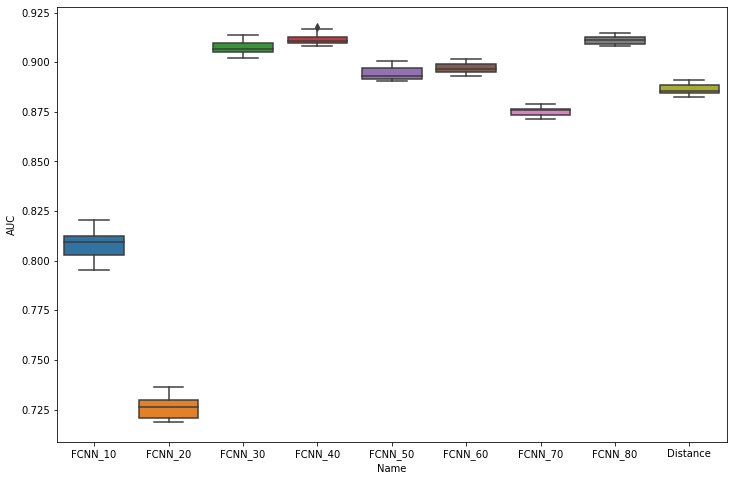

In [32]:
plt.figure(figsize=(12,8))
sns.boxplot(data = t,x='Name',y='AUC')

In [17]:
# find the max AUC configuration
max_weight = auc_df[auc_df['AUC'] ==auc_df.max()[3]] 
w1,w2,w3 = max_weight.values[0][:3]

# get the suitability map using the above weights
max_map = suitability_maps.select('DEM').multiply(w1)\
                         .add(suitability_maps.select('SLOPE').multiply(w2))\
                         .add(suitability_maps.select('Distance').multiply(w3))\
                         .divide((w1+w2+w3)*255)

# # export the max_map
# task = ee.batch.Export.image.toCloudStorage(
#     image = max_map.multiply(255).toUint8(),
#     description=f'Max_suit_map_{t0}_and_{t1}_prj_{t2}',
#     bucket='tf-gee',
#     fileNamePrefix= f'Urban_projection/Max_suit_map_{t0}_and_{t1}_prj_{t2}.tif',
#     region=region.geometry().bounds(),
#     scale=30,
#     maxPixels=int(1e13),
#     skipEmptyTiles=True)

# task.start()